# GoF from binned cost functions

The builtin cost functions for binned data, `BinnedNLL` and `ExtendedBinnedNLL` have a minimum value which is asymptotically chi2-distributed and thus can be used as a goodness-of-fit statistic. This example shows, that one still needs a large number of entries in each bin to reach the asymptotic regime.

In [1]:
from iminuit import Minuit
from iminuit.cost import BinnedNLL, ExtendedBinnedNLL, LeastSquares
import numpy as np
from numba_stats import norm, expon
import matplotlib.pyplot as plt
import joblib
from scipy.stats import chi2

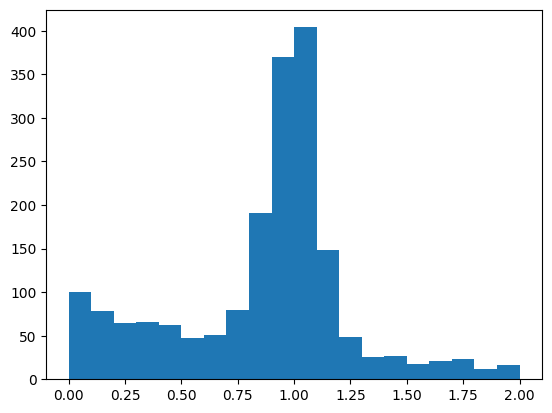

In [2]:
def generate(n, seed):
    rng = np.random.default_rng(seed)
    s = rng.normal(1, 0.1, size=rng.poisson(n))
    b = rng.exponential(size=rng.poisson(n))
    x = np.append(s, b)
    return x[(x > 0) & (x < 2)]

x = generate(1000, 1)
plt.hist(x, bins=20, range=(0, 2));

In [3]:
@joblib.delayed
def run(n, seed):
    x = generate(n, seed)
    xrange = (0, 2)
    w, xe = np.histogram(x, bins=20, range=xrange)

    def model1(x, z, mu, sigma, tau):
        return z * norm.cdf(x, mu, sigma) / np.diff(norm.cdf(xrange, mu, sigma)) + (1 - z) * expon.cdf(x, 0, tau) / np.diff(expon.cdf(xrange, 0, tau))

    def model2(x, s, b, mu, sigma, tau):
        return s * n * norm.cdf(x, mu, sigma) + b * n * expon.cdf(x, 0, tau)

    m = [
        Minuit(BinnedNLL(w, xe, model1), z=0.5, mu=0.5, sigma=0.5, tau=0.5),
        Minuit(ExtendedBinnedNLL(w, xe, model2), s=1, b=1, mu=0.5, sigma=0.5, tau=0.5),
    ]
    for mi in m:
        mi.limits["mu"] = (0, 2)
        mi.limits["sigma", "tau"] = (0.1, None)
    m[0].limits["z"] = (0, 1)
    m[1].limits["s", "b"] = (0, None)
    r = []
    for mi in m:
        mi.migrad()
        if mi.valid:
            pvalue = 1 - chi2(mi.fcn._fcn.ndata - mi.nfit).cdf(mi.fval)
            r.append(pvalue)
        else:
            r.append(np.nan)
    return r

pvalues = {}
for n in (20, 100, 1000, 10000):
    pvalues[n] = np.array(joblib.Parallel(-1)(run(n, i) for i in range(500)))

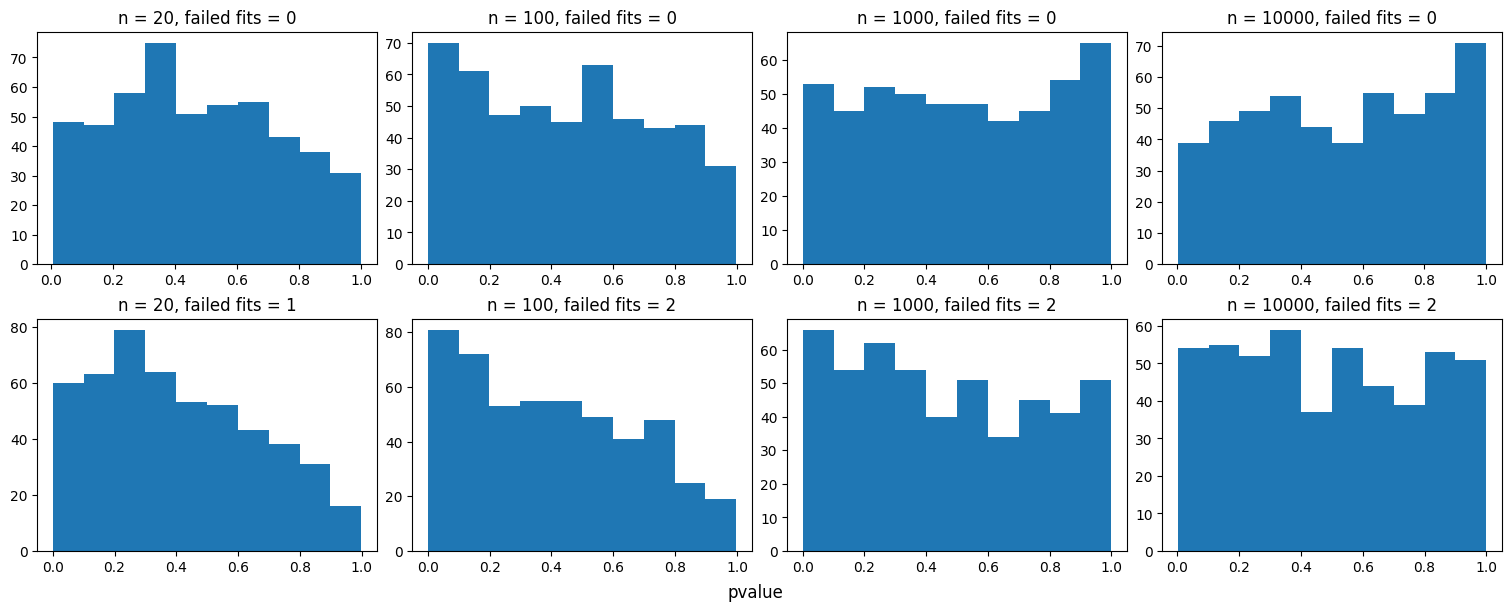

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(15, 6), constrained_layout=True)
for i, (ni, vi) in enumerate(pvalues.items()):
    ax[0, i].hist(vi[:, 0])
    ax[1, i].hist(vi[:, 1])
    ax[0, i].set_title(f"n = {ni}, failed fits = {np.sum(np.isnan(vi[:, 0]))}")
    ax[1, i].set_title(f"n = {ni}, failed fits = {np.sum(np.isnan(vi[:, 1]))}")
fig.supxlabel("pvalue");